In [14]:
%store -r electric_vehicle_df

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

How old are EV and plug-in hybrids in the state? Is there a significant age difference between the two EV types? 

From the electric_vehicle_df we will use a subset with only the "Model Year"and "Electric Vehicle Type" to address this question.

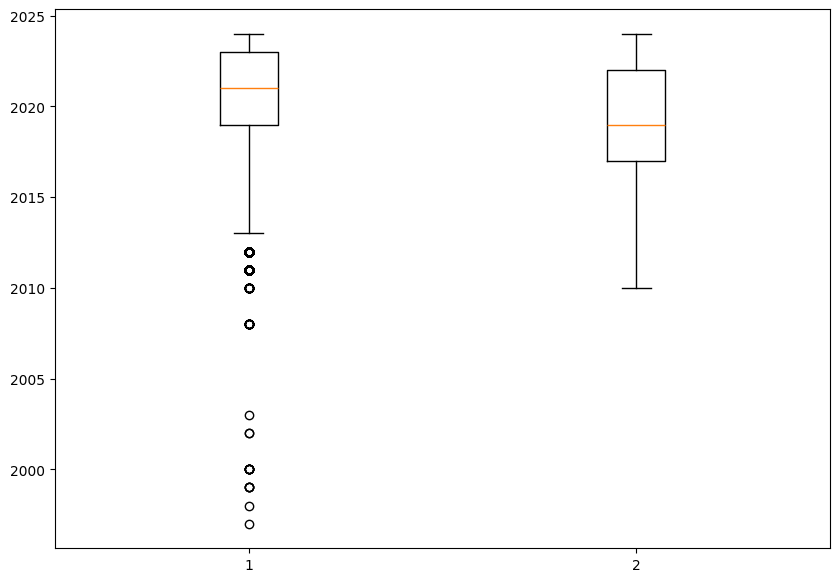

In [23]:
ev_q4_df = electric_vehicle_df[["Model Year", "Electric Vehicle Type"]]
ev_BEV_df = ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)"]
ev_PHEV_df = ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)"]

BEV = ev_BEV_df["Model Year"]
PHEV = ev_PHEV_df["Model Year"]
q4_data = [BEV, PHEV]

fig = plt.figure(figsize =(10, 7))
plt.boxplot(q4_data)

plt.show()

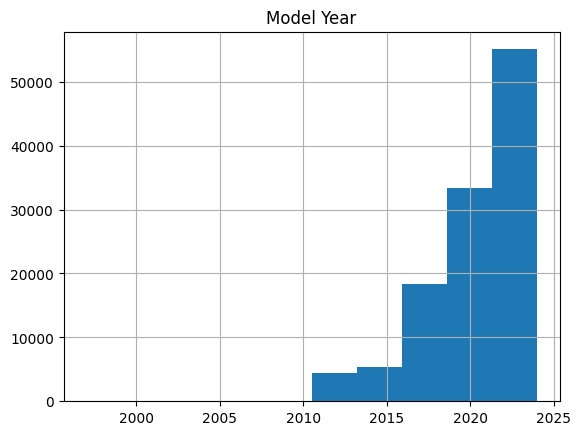

In [24]:
ev_BEV_df.hist(column="Model Year");

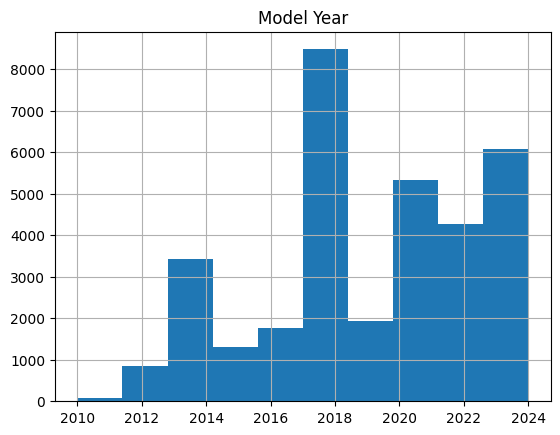

In [25]:
ev_PHEV_df.hist(column="Model Year");

Both BEV and PHEV are skewed to the left. The BEVs have outliers in the earlier years with the highest consentration in the recent years. PHEVs have the highest concentration in 2018 and a smaller range.

In [26]:
ev_q4_summary = pd.DataFrame(
    {"EV Type": ["Battery Electric Vehicle (BEV)","Plug-in Hybrid Electric Vehicle (PHEV)"],
     "mean": [ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)"]["Model Year"].mean().round(2), 
             ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)"]["Model Year"].mean().round(2)],
     'std dev': [ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)"]["Model Year"].std(), 
                ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)"]["Model Year"].std()],
     'N': [len(ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)"]),
           len(ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)"])]
    })
ev_q4_summary

,EV Type,mean,std dev,N
0,Battery Electric Vehicle (BEV),2020.31,2.857224,116585
1,Plug-in Hybrid Electric Vehicle (PHEV),2018.94,3.293162,33556


Variences are not equal so t-test with unpooled variences is used to see if the means are significantly different from each other.

In [27]:
ev_q4_test = pd.DataFrame(
                {"Battery Electric Vehicle (BEV)": ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)"]["Model Year"],
                 "Plug-in Hybrid Electric Vehicle (PHEV)": ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)"]["Model Year"]})

from pingouin import ttest

ttest(ev_q4_test["Battery Electric Vehicle (BEV)"], ev_q4_test["Plug-in Hybrid Electric Vehicle (PHEV)"], correction = True)

C:\Users\amdur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,69.393475,49008.463712,two-sided,0.0,"[1.34, 1.41]",0.464844,inf,1.0


P-value is less than significance value of 0.05 so we reject the null hypothesis and conclude that the means are different.

In [28]:
ev_q4_test.describe()

,Battery Electric Vehicle (BEV),Plug-in Hybrid Electric Vehicle (PHEV)
count,116585.000000,33556.000000
mean,2020.314534,2018.938491
std,2.857224,3.293162
min,1997.000000,2010.000000
25%,2019.000000,2017.000000
50%,2021.000000,2019.000000
75%,2023.000000,2022.000000
max,2024.000000,2024.000000


In [29]:
ev_q4_df.head()

,Model Year,Electric Vehicle Type
0,2020,Battery Electric Vehicle (BEV)
1,2022,Plug-in Hybrid Electric Vehicle (PHEV)
2,2023,Plug-in Hybrid Electric Vehicle (PHEV)
3,2018,Battery Electric Vehicle (BEV)
4,2018,Plug-in Hybrid Electric Vehicle (PHEV)


Convert the "Electric Vehicle Type" to categories for modeling purposes.

In [30]:
ev_q4_model_df = ev_q4_df
ev_q4_model_df["Electric Vehicle Type"] = ev_q4_model_df["Electric Vehicle Type"].astype("category")
cat_columns = ev_q4_model_df.select_dtypes(['category']).columns
ev_q4_model_df[cat_columns] = ev_q4_model_df[cat_columns].apply(lambda x: x.cat.codes)
ev_q4_model_df.head()

C:\Users\amdur\AppData\Local\Temp\ipykernel_18376\3263908725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_q4_model_df["Electric Vehicle Type"] = ev_q4_model_df["Electric Vehicle Type"].astype("category")
C:\Users\amdur\AppData\Local\Temp\ipykernel_18376\3263908725.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_q4_model_df[cat_columns] = ev_q4_model_df[cat_columns].apply(lambda x: x.cat.codes)


,Model Year,Electric Vehicle Type
0,2020,0
1,2022,1
2,2023,1
3,2018,0
4,2018,1


For the model, 0 represents BEVs and 1 represents PHEVs.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(ev_q4_model_df.drop("Electric Vehicle Type",axis=1), ev_q4_model_df["Electric Vehicle Type"], test_size=0.3, random_state=88)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87     35008
           1       0.00      0.00      0.00     10035

    accuracy                           0.78     45043
   macro avg       0.39      0.50      0.44     45043
weighted avg       0.60      0.78      0.68     45043



C:\Users\amdur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amdur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amdur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[35008     0]
 [10035     0]]


The logistic regression is unsuccessful at predicting the PHEVs based on the year of the vehicle. 

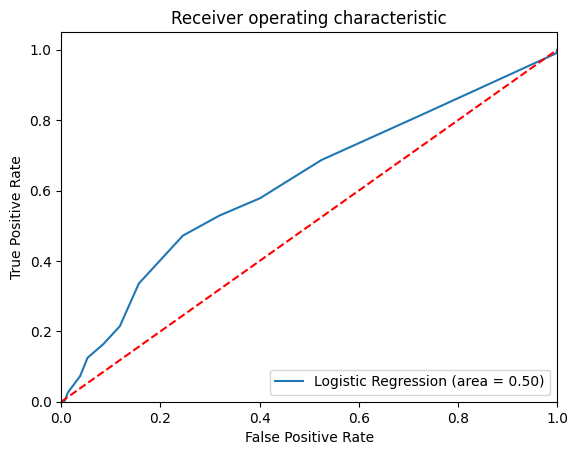

In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()